# Wine Data Set
Authors:  
- Minh Duc Ngo  
- Catharina Hoppensack  

This notebook is our own work. Any other sources have been clearly marked and cited.

All authors contributed equally.

Goal:
Our goal is to predict the quality of the wine based on different chemical measurments.


Before we started, we prepared our Coding environment and packages we have chosen.

# 1 Environment
- Python version: (3.10.19) 3.11.7  
- OS: Windows 11  
- Environment: Visual Studio Code

### Packages

With execution of the following code cell, all libraries used in this jupyter notebook will be downloded. You may need to restart the kernel to use updated packages.

In [84]:
#install all basic libraries
%pip install seaborn matplotlib pandas numpy scikit-learn torch torchvision torchaudio



Note: you may need to restart the kernel to use updated packages.


In [85]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import torch
import torch.nn as nn

# 2 Load Data 
_Describe in detail their origin, content, structures and data types._

### Description of Data

The data is loaded from an URL-Link and saved in a variable. With the help of pandas, we can read the csv file and safe the data, thats seperated by a semicolon.

In [86]:
url  = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
df_original = pd.read_csv(url, sep=";")
print(df_original.describe(include='all'))

       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806   
std         1.741096          0.179060     0.194801        1.409928   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1599.000000          1599.000000           1599.000000  1599.000000   
mean      0.087467            15.874922             46.467792     0.996747   
std       0.047065            10.460157             32.895324     0.001887   
min       0.012000             1.000000         

The dataset originates from UCI Maschine Learning Repository and cointains 1599 samples with 11 chemical features and 1 target variable: quality.

# 3  Data Exploration
_Prepare statistical and visual data summaries._  

_How many variables/features does the data contain, how many samples? Are there missing values? Explore correlations among variables and conduct at least one unsupervised analysis. Consider variable transformations and normalizations where applicable._


In [87]:
(print("Statistical Summary:"))
print(df_original.info())
print(df_original.shape)
print("/nMissing Values in each column:")
print(df_original.isna().sum())

Statistical Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB
None
(1599, 12)
/nMissing Values in each column:
fixed acidity           0
volatile acidity        0
citr

As we can see from the statistical summary:
- 12 features/variables 
- no missing values
- all numerical, all float, 1 int (quality)
- 1599 samples/rows: 0 - 1598

Now we take a look at any duplicates in the DataFrame.

In [88]:
dups = df_original.duplicated().sum()
print("Duplicates:", dups)

#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.duplicated.html

Duplicates: 240


Since there are some duplicates, we decided to get rid of them to avoid disproportional weighting on certain datasets.  
It must be stated, that these measures can be coincidentally if certain wine types happen to have similar values in each feature. It can also be, that accidentally certain wines were tested multiple times.

In [89]:
print("Before   :", df_original.shape)
df_noDuplicates = df_original.drop_duplicates()
print("After  :", df_noDuplicates.shape)

Before   : (1599, 12)
After  : (1359, 12)


To visualise the difference between the original and the version without the duplicates, we created a graph comparing them together.

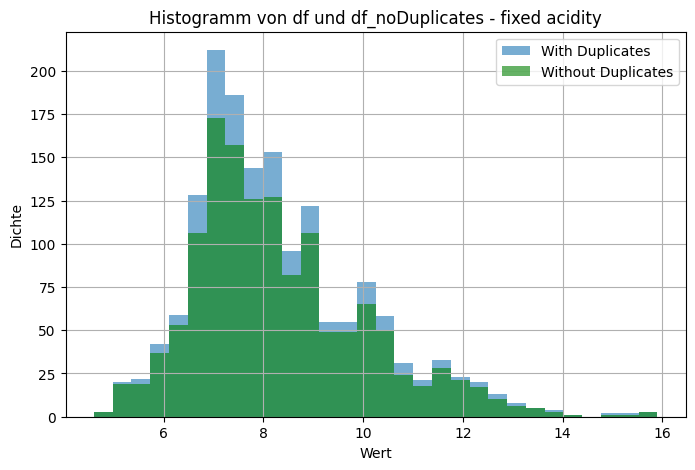

In [90]:
plt.figure(figsize=(8, 5))

# Beide Histogramme im gleichen Plot darstellen
plt.hist(df_original['fixed acidity'], bins=30, alpha=0.6, label ='With Duplicates')
plt.hist(df_noDuplicates['fixed acidity'], bins=30, alpha=0.6, color='green', label ='Without Duplicates')

# Achsenbeschriftung und Legende
plt.xlabel('Wert')
plt.ylabel('Dichte')
plt.title('Histogramm von df und df_noDuplicates - fixed acidity')
plt.legend()
plt.grid(True)

plt.show()

The following charts show how the values in each feature live on different scales. We can also see some skewness in some of the features, for example in residual sugar.  
  
The last subplot in the bottom right corner shows the distribution of wine quality. As we can see, the most wines are around the wine quality value of 5 and 6.
This means, the accuracy of the predicition of wine with quality values 3, 4, 7 and 8 might be weaker.

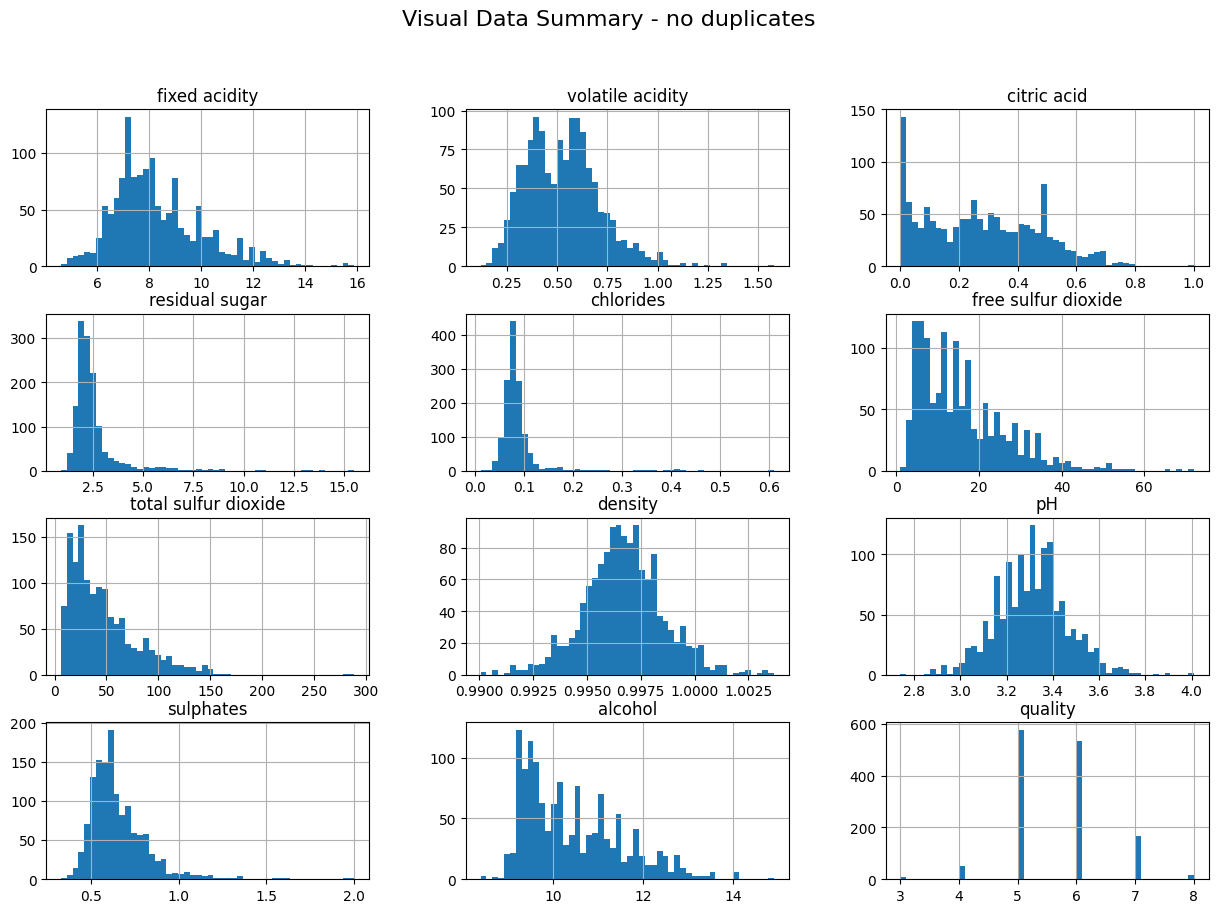

In [91]:
df_noDuplicates.hist(figsize=(15,10), bins=50) #bins anpassen
plt.suptitle("Visual Data Summary - no duplicates", fontsize=16)
plt.show()
#Motivation: see distributions of features individually -> clear to see skewness, outliers, normality, less chaos
#Negative  : might be to big

#none equally distributed
#some skewed right: residual sugar, chlorides, free sulfur dioxide, total sulfur dioxide
#some approx normal: fixed acidity, citric acid, pH, sulphates, alcohol
#some approx uniform: volatile acidity, density 

### Log Transformation for every suitable Feature (Cathy)

As seen in the histograms below, the log-transformation reduces skewness. That means the large value range has been compressed. This helps to reduce the influence of extreme outliers.

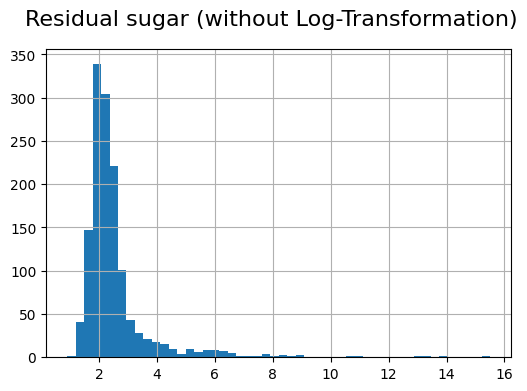

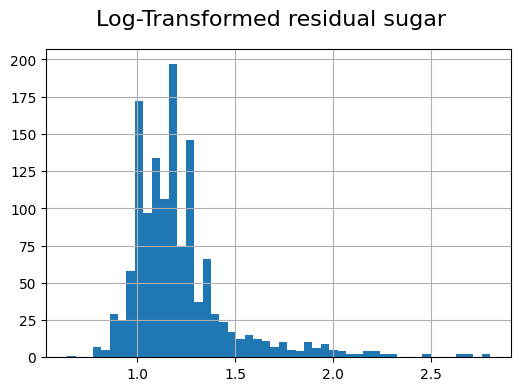

values before log transformation
count    1359.000000
mean        2.523400
std         1.352314
min         0.900000
25%         1.900000
50%         2.200000
75%         2.600000
max        15.500000
Name: residual sugar, dtype: float64


values after log transformation
count    1359.000000
mean        1.216325
std         0.263457
min         0.641854
25%         1.064711
50%         1.163151
75%         1.280934
max         2.803360
Name: residual sugar, dtype: float64


In [92]:
#Kopie damit Original nicht manipuliert wird zum Visualisieren
showcase_df = df_noDuplicates.copy()

df_noDuplicates["residual sugar"].hist(figsize=(6,4), bins=50)
plt.suptitle("Residual sugar (without Log-Transformation)", fontsize=16)
plt.show()


showcase_df['residual sugar'] = np.log1p(showcase_df['residual sugar'])
showcase_df["residual sugar"].hist(figsize=(6,4),bins=50)
plt.suptitle("Log-Transformed residual sugar", fontsize=16)
plt.show()

print("values before log transformation")
print(df_noDuplicates["residual sugar"].describe())
print("\n")
print("values after log transformation")
print(showcase_df["residual sugar"].describe())
#log transformation to reduce skewness
#makes it more evenly distributed 
#more beautiful

Comparing those graphs we can see that it got smaller numberwise. Visually it is quite difficult to see huge differneces, therefore we visualised them in one graph together.

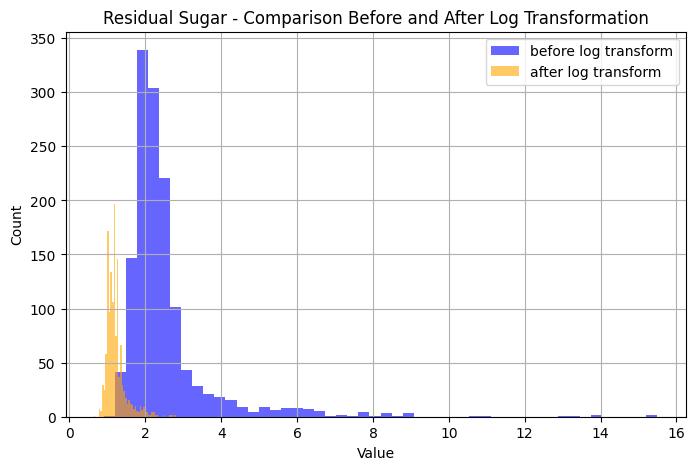

In [93]:
plt.figure(figsize=(8, 5))

# Beide Histogramme im gleichen Plot darstellen
plt.hist(df_noDuplicates['residual sugar'], bins=50, alpha=0.6, color='blue', label ='before log transform')

plt.hist(showcase_df['residual sugar'], bins=50, alpha=0.6, color='orange', label ='after log transform')


# Achsenbeschriftung und Legende
plt.xlabel('Value')
plt.ylabel('Count')
plt.title('Residual Sugar - Comparison Before and After Log Transformation')
plt.legend()
plt.grid(True)

# Anzeigen
plt.show()

In the following code blocks, we apply this log-transformation to any feature whose skewness is greater than or equal to 1.

In [94]:
#features OHNE Quality
features = ["fixed acidity", "volatile acidity", "citric acid", 
            "residual sugar", "chlorides", "free sulfur dioxide",
            "total sulfur dioxide", "density", "pH", "sulphates", "alcohol"]
            
#zur Bestimmung, ob Transformation nötig ist
log_features = []
for feat in features:
    skew = df_noDuplicates[feat].skew()
    if skew >= 1:
        log_features.append(feat)

    '''
    print(feat)
    print("Skewness vor:", df_noDuplicates[feat].skew())
    print("Skewness nach:", np.log1p(df[feat]).skew())
    print("\n")
    '''
print("Relevant Features:\n")
for i in log_features:
    print(i)

Relevant Features:

residual sugar
chlorides
free sulfur dioxide
total sulfur dioxide
sulphates


In [95]:
#Kopie des ursprünglichen Dataframes
df_transformed = df_noDuplicates.copy()

for logfeat in log_features:
    #neue Werte für transformierte Features
    df_transformed[logfeat] = np.log1p(df_original[logfeat])

To make it easier for the model to learn, we will normalize the data so the mean of each feature set is centered at 0.  
  
We can see in the shape of the data, that the test data has fewer datasets than the train data.  
    
The sum of the test and training data sets corresponds to the total size (rows) of the original data frame.  
  
The splitting in test and training data is done to make the evaluation of the model more accurate.

X_tensor_train.shape: torch.Size([1087, 11])  y_tensor_train.shape: torch.Size([1087])
X_tensor_test.shape:  torch.Size([272, 11])   y_tensor_test.shape:  torch.Size([272])
df_noDuplicates.shape: (1359, 12)
df_transformed.shape: (1359, 12)


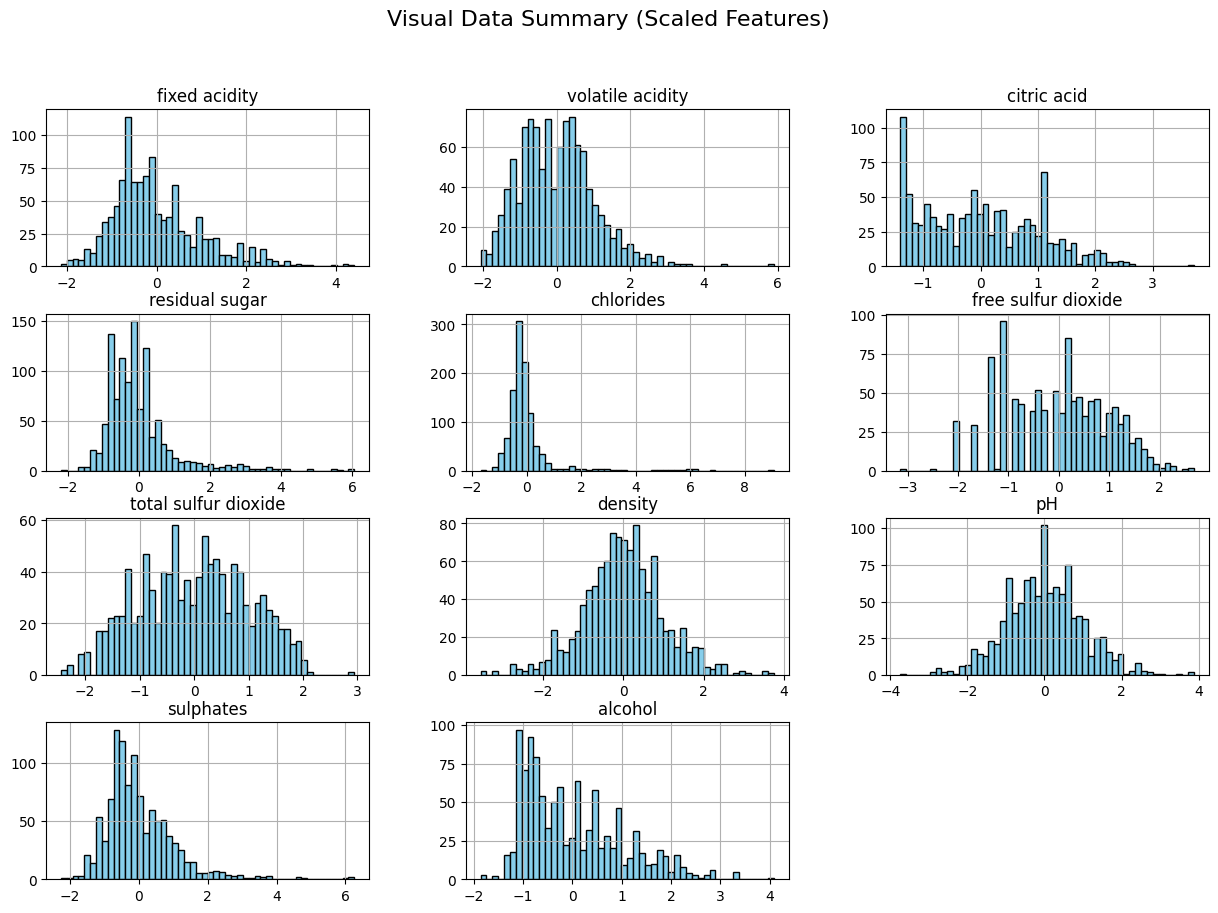

In [96]:
#normalization
y_np = df_noDuplicates['quality'].to_numpy()      #defining target variable and converting to numpy
X_np = df_transformed[features].to_numpy()       #speichern der Daten fürs Training (alle außer quality)

scaler = StandardScaler() #normalization object

#splitten beugt Leakage vor. Modell lernt nicht mit allen schon richtigen Daten.  -> Overfitting vermeiden |Was ist Leakage? A:wenn sozusagen die falschen daten (testdaten) dem modell bekannt gemacht werden. 
#Testdaten werden zur Überprüfung des Modells benutzt
X_np_train, X_np_test, y_np_train, y_np_test = train_test_split(
    X_np, y_np, test_size=0.2, random_state=42)           #random_state für Reproduzierbarkeit

X_np_train_scaled = scaler.fit_transform(X_np_train) #das fitten nur auf die trainingsdaten
X_np_test_scaled = scaler.transform(X_np_test) #normalisierung auf beide

# Convert back to torch                                     
# PyTorch benötigt Tensoren als Eingabe
X_tensor_train = torch.tensor(X_np_train_scaled, dtype=torch.float32)
X_tensor_test  = torch.tensor(X_np_test_scaled, dtype=torch.float32)
y_tensor_train = torch.tensor(y_np_train, dtype=torch.float32)
y_tensor_test  = torch.tensor(y_np_test, dtype=torch.float32)

print(f'X_tensor_train.shape: {X_tensor_train.shape}  y_tensor_train.shape: {y_tensor_train.shape}')
print(f'X_tensor_test.shape:  {X_tensor_test.shape}   y_tensor_test.shape:  {y_tensor_test.shape}')
print(f'df_noDuplicates.shape: {df_noDuplicates.shape}')
print(f'df_transformed.shape: {df_transformed.shape}')

df_scaled = pd.DataFrame(X_np_train_scaled, columns=features)

df_scaled.hist(figsize=(15,10), bins=50, color='skyblue', edgecolor='black')
plt.suptitle("Visual Data Summary (Scaled Features)", fontsize=16)
plt.show()

#https://datascientest.com/de/train-test-split
#https://www.youtube.com/watch?v=_tex9QxBX-U

### Correlations between all features (Duc)

Now we measure how each feature influences the quality

If the value rises proportional to the risen value of quality, then it's a positive correlation.  
If the value drops proportional to the sunken value of quality, then its a negative correlation.  
If they are irrelevant to each other, then its a neutral correlation.  

If the correlation is not neutral, the value of the chosen feature changes in proportion to the value of the correlation to Quality.


Here we created a heatmap, where the corrolation of each feature to each feature is.

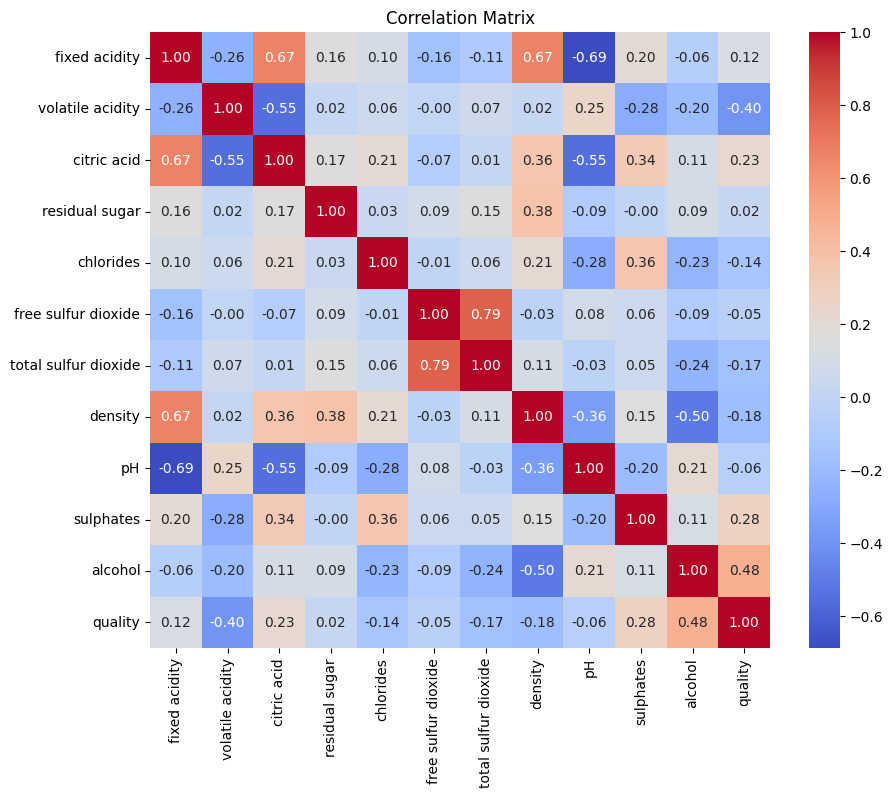

In [97]:
corr_matrix = df_transformed.corr('pearson')
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

As we only need the correlation for the quality feature, we dismissed the others and displayed it statistically and visually

In [98]:
corr_with_quality = corr_matrix["quality"].sort_values(ascending=False)
print(corr_with_quality)


quality                 1.000000
alcohol                 0.480343
sulphates               0.279517
citric acid             0.228057
fixed acidity           0.119024
residual sugar          0.020154
free sulfur dioxide    -0.047132
pH                     -0.055245
chlorides              -0.137302
total sulfur dioxide   -0.165289
density                -0.184252
volatile acidity       -0.395214
Name: quality, dtype: float64


### Visualization of Correlation with Quality

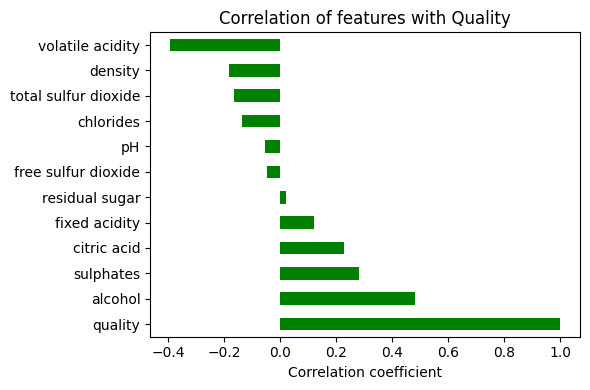

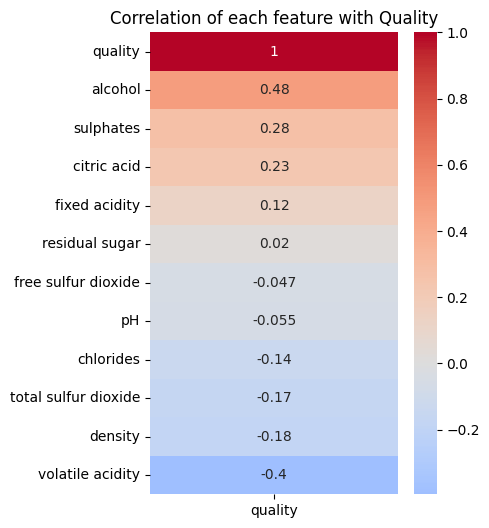

In [99]:
plt.figure(figsize=(6,4))
corr_with_quality.plot(kind='barh', color='green')
plt.title("Correlation of features with Quality")
plt.xlabel("Correlation coefficient")
plt.tight_layout()
plt.show()

corr = df_transformed.corr(numeric_only=True)[["quality"]].sort_values(by="quality", ascending=False)

plt.figure(figsize=(4,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation of each feature with Quality")
plt.show()

None of the features is neutral to quality.
Ex.: If quality rises by 1, then residual sugar rises by 0.013732

### Unsupervised Clustering

Unsupervised clustering analyzes data and automatically groups similar items together. It looks for patterns or structures without any prior labels or guidance.

The following plots show the correlation between features with the addition of differentiating between clusters. We can see a lot of overlapping between the clusters, but the overall picture is not entirely clear. Also there are way too many subplots to analyse.

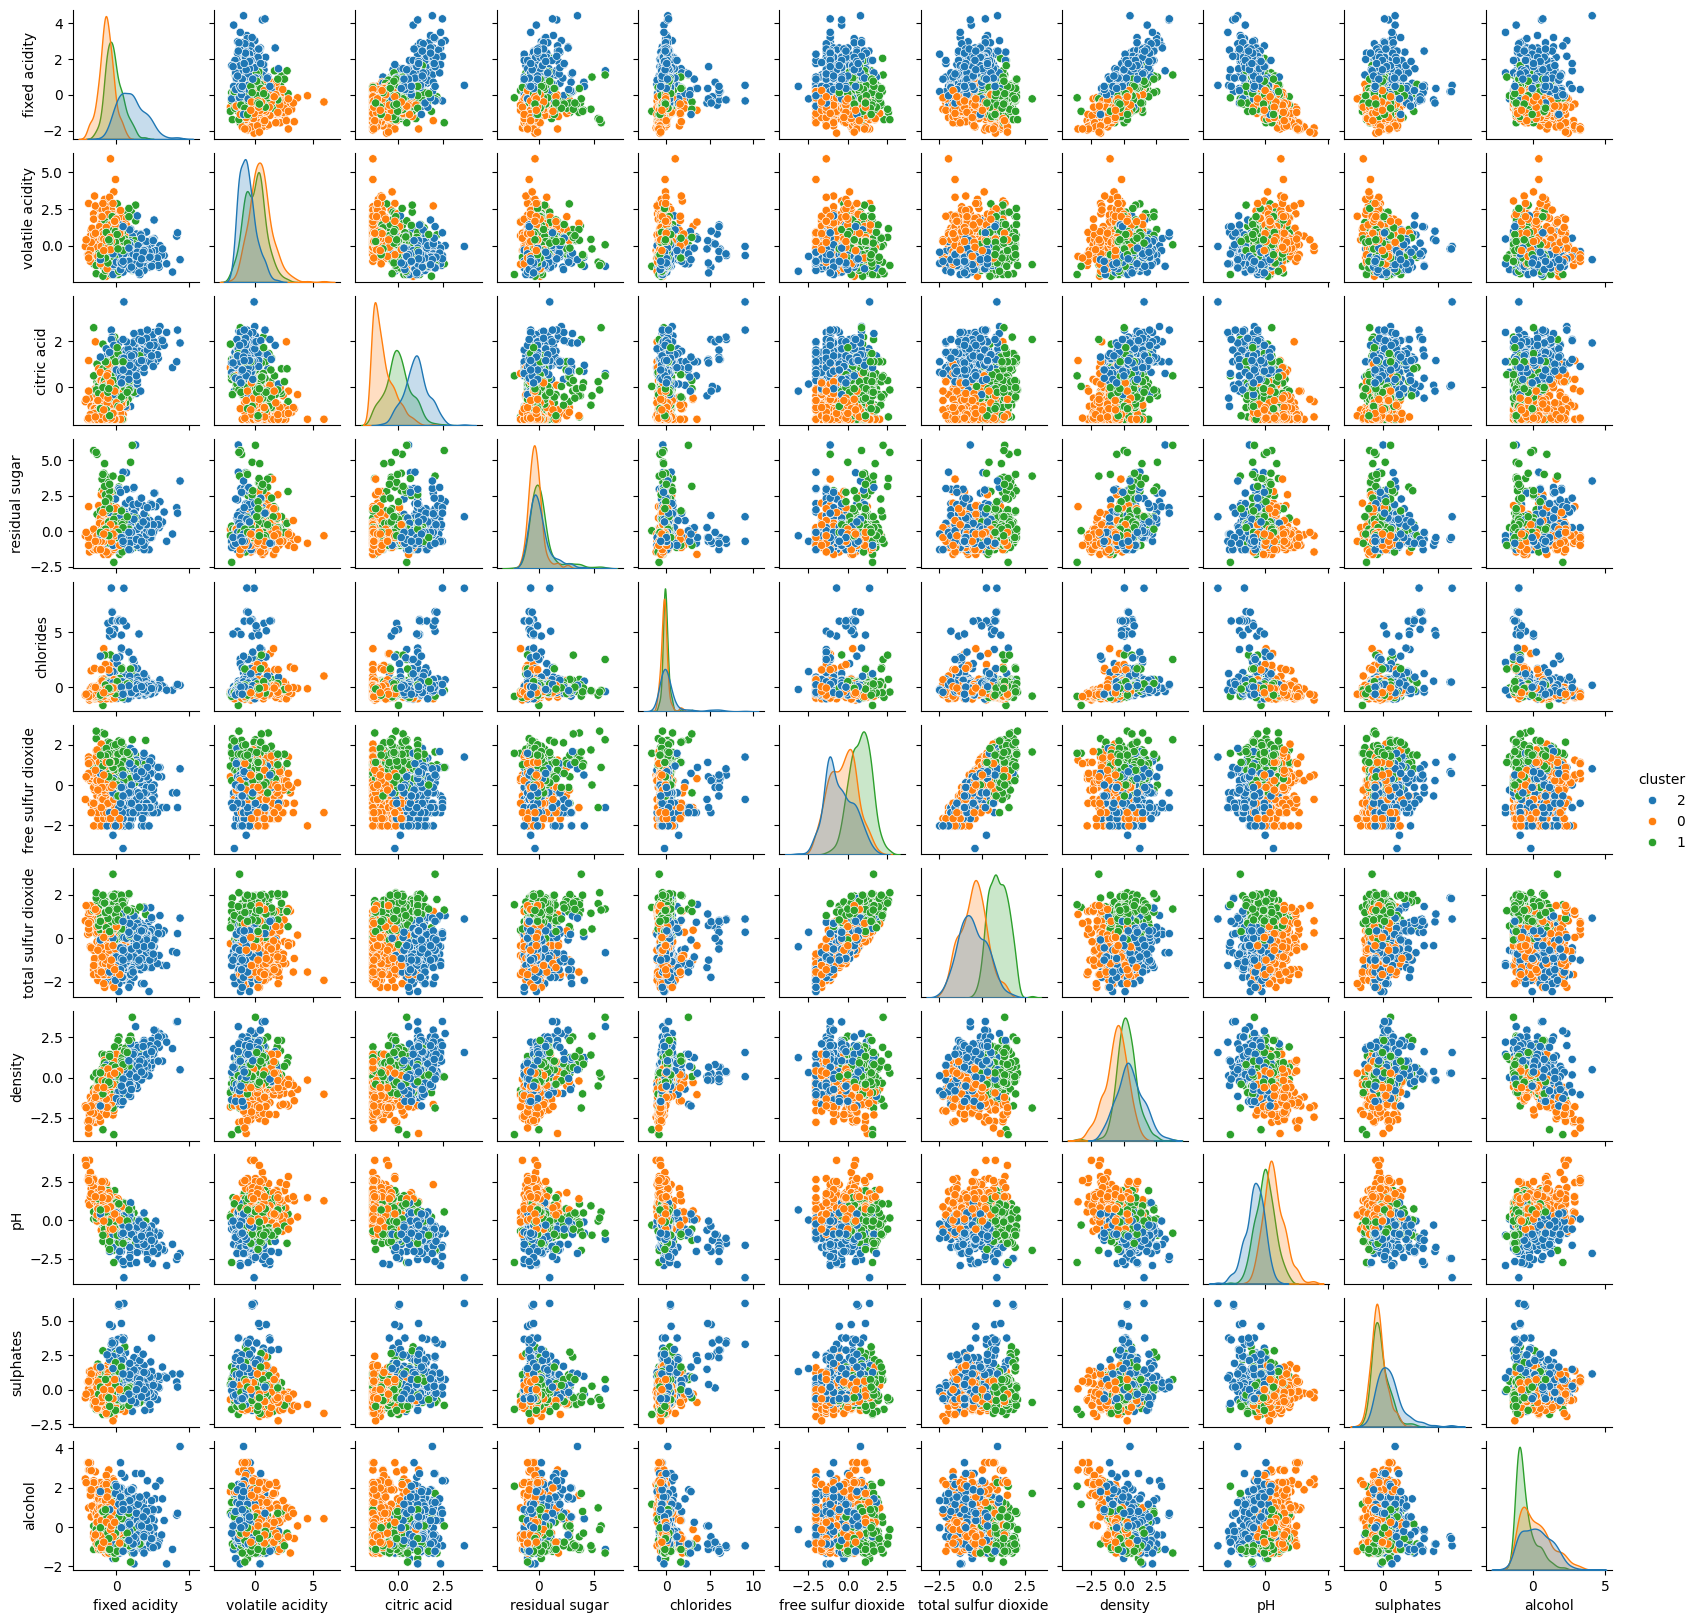

In [100]:
kmeans = KMeans(n_clusters=3)
labels = kmeans.fit_predict(X_np_train_scaled)
#neue Spalte "cluster"
df_scaled["cluster"] = labels.astype(str) #wandelt labels in Strings um, damit seaborn sie besser für Farben nutzen kann

sns.pairplot(df_scaled, hue="cluster", height=1.5, aspect=1.0)


A K-Means clustering with 3 clusters was applied to the normalized wine data.
The goal was to group wines based on their chemical properties, such as acidity, sugar, and alcohol, without using the quality label.

The data was normalized before clustering to make all variables comparable.
The pairplot visualizes all variable combinations, where each point represents a wine and each color represents a cluster.

Some clusters show slight separation in certain features (for example, citric acid or chlorides),
while others overlap, indicating that the wines share similar chemical characteristics.
Overall, the clustering reveals some structure in the data, but the groups are not perfectly distinct.

To visualize the clusters better, we can compress the dataframe to lesser dimensions. Here we chose 2 dimensions. This plot shows, that the prior calculated 3 clusters indeed show a distinct seperation.

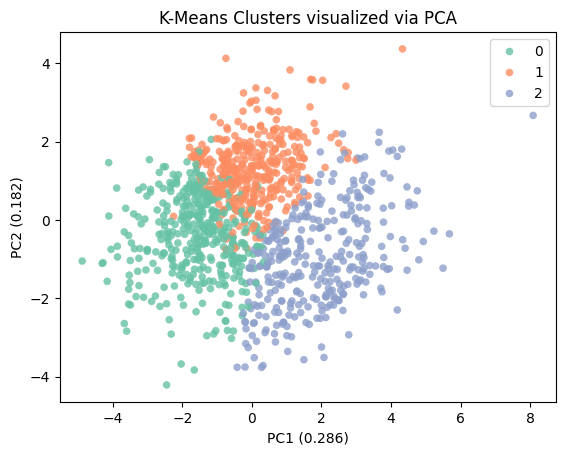

In [101]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_np_train_scaled)
var_exp = pca.explained_variance_ratio_

xlab = f"PC1 ({var_exp[0]:.3f})"
ylab = f"PC2 ({var_exp[1]:.3f})"

sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1],
                hue=labels, palette="Set2", s=30, edgecolor="none", alpha=0.8)
plt.xlabel(xlab)
plt.ylabel(ylab)
plt.title("K-Means Clusters visualized via PCA")
plt.show()

It summarises all the features and displays the most important differences.  
-> show if the wines are similar or unsimilar - even without knowing the quality

0.182 + 0.286 = 0.468 & of Information from the original data is intact

Another approach to see which feataures are more prominent in which cluster is by defining the mean of each cluster for each feature. This way we can not only see differences between the clusters, but also which feature is relatively high or low in which cluster. 
The following heatmap shows for example a high value for fixed acidity and citric acid in one cluster while another shows a very low value of these two.

         fixed acidity  volatile acidity  citric acid  residual sugar  \
cluster                                                                 
0            -0.694495          0.511984    -0.827465       -0.278249   
1            -0.158082         -0.004273     0.004378        0.227833   
2             1.042315         -0.629898     1.020934        0.083801   

         chlorides  free sulfur dioxide  total sulfur dioxide   density  \
cluster                                                                   
0        -0.218965            -0.303477             -0.473417 -0.588866   
1        -0.085675             0.791998              0.964740  0.235560   
2         0.369709            -0.531686             -0.519016  0.460071   

               pH  sulphates   alcohol  
cluster                                 
0        0.690513  -0.348296  0.223640  
1       -0.019476  -0.183911 -0.496568  
2       -0.833822   0.642683  0.291989  


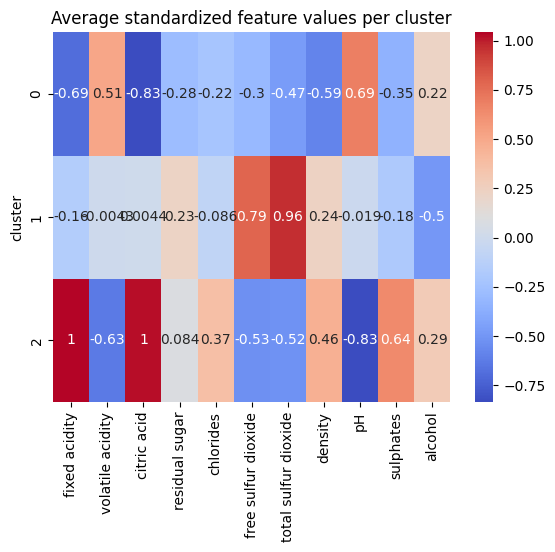

In [102]:
cluster_means = df_scaled.groupby("cluster").mean()
print(cluster_means)

sns.heatmap(cluster_means, cmap="coolwarm", annot=True)
plt.title("Average standardized feature values per cluster")
plt.show()

To see if Clusters show differences in quality, we can compare these two features within a crosstable. One Cluster for example has a lot more datasets for quality value 5 than the other two. This could lead to the assumption, that correlations between other features could predict the quality of a wine.

In [103]:
pd.crosstab(df_transformed["quality"], df_scaled["cluster"])

cluster,0,1,2
quality,,,
3,1,2,2
4,12,13,7
5,160,127,131
6,119,124,92
7,38,46,41
8,3,2,5


# 4 Data Model
_Define what you want to model and choose an appropriate model framework. Define a simple baseline model and a loss function - theoretically and practically. Explain the model in terms of input-output data structures and dimensions._

### Supervised Learning: Linear Model x -> y

From this point onward, we move into the modeling phase of our project.
After cleaning and exploring the dataset, we now want to build a model that predicts wine quality based on its chemical properties.
We’ll start with a simple baseline model and then gradually increase the model’s complexity — up to a neural network.

In [104]:
#linear model - linear regression
model = nn.Sequential(nn.Linear(1, 1)) # n_in = 1, n_out = 1

# baseline model: y​=w⋅x+b |w= weights = wie stark es die Qualität beeinflusst, b=bias = Verschiebung der Linie
# MSE == Mean Squared Error
loss_func_MSE = nn.MSELoss()

#SGD == Stochastic Gradient Descent
optimizer_SGD = torch.optim.SGD(model.parameters()) #optimiert w & b, damit loss minimiert wird

In [105]:
#defining the column/feature name for the input data
feat_name = "volatile acidity"
feat_index = features.index(feat_name)

# Extracting that feature from training and test data
x_basic_tr = torch.as_tensor(X_tensor_train[:, feat_index], dtype=torch.float32).view(-1, 1)
x_basic_te = torch.as_tensor(X_tensor_test[:,  feat_index], dtype=torch.float32).view(-1, 1)

# Target variable (wine quality)
y_basic_tr = torch.as_tensor(y_tensor_train, dtype=torch.float32).view(-1, 1)
y_basic_te = torch.as_tensor(y_tensor_test, dtype=torch.float32).view(-1, 1)

print(f"shape(x_basic_tr): {x_basic_tr.shape}")
print(f"shape(y_basic_tr): {y_basic_tr.shape}")

print(f"shape(x_basic_te): {x_basic_te.shape}")
print(f"shape(y_basic_te): {y_basic_te.shape}")

shape(x_basic_tr): torch.Size([1087, 1])
shape(y_basic_tr): torch.Size([1087, 1])
shape(x_basic_te): torch.Size([272, 1])
shape(y_basic_te): torch.Size([272, 1])


Here, we extract only the “volatile acidity” feature from our dataset.
The model will try to learn how this acidity value influences the overall wine quality.

# 5 Train Model
_Define Train and Test Data and run the training loop. Monitor the behaviour of the loss function._

We already plitted the data into test and train data in chapter 3 when we also transformed and normalized the data.   
In this step we collect the losses in an array to plot them later. We use the train data (x_basic_tr) for training the model. The epochs are set to 1000.

In [106]:
losses = []
model.train()
for epoch in range(1000):
    optimizer_SGD.zero_grad()
    y_pred_basic_tr = model(x_basic_tr)
    loss = loss_func_MSE(y_pred_basic_tr, y_basic_tr) #vergleicht Vorhersage mit echten Werten
    loss.backward()
    optimizer_SGD.step()
    losses.append(loss.item())  #wandelt loss in float um und speichert es

# 6 Evaluate Model
_Run model predictions on the test data set. Calculate and visualize the appropriate metrics to evaluate model performance. Explain why a separate test data set should be used for such evaluations._

We use the before splittet test data set to evaluate our model and NOT the train data. Since the model has never seen this data before, it is a better representation of the models accuracy. If a model predicts outcomes using the same data it has been used for training, the model is too closely aligned with the known data, which could bias the result. This is also called "overfitting".

In [107]:
model.eval()
with torch.no_grad():
    y_pred_basic_te = model(x_basic_te)                         #using test data to evaluate
    test_loss = loss_func_MSE(y_pred_basic_te, y_basic_te).item()

print("Final train loss:", losses[-1])
print("Test loss:", test_loss)
for name, p in model.named_parameters():
    print(name, p.detach())

Final train loss: 1.028503656387329
Test loss: 0.9503973722457886
0.weight tensor([[-0.2388]])
0.bias tensor([4.9675])


The following chart shows that the losses decrease with each iteration.

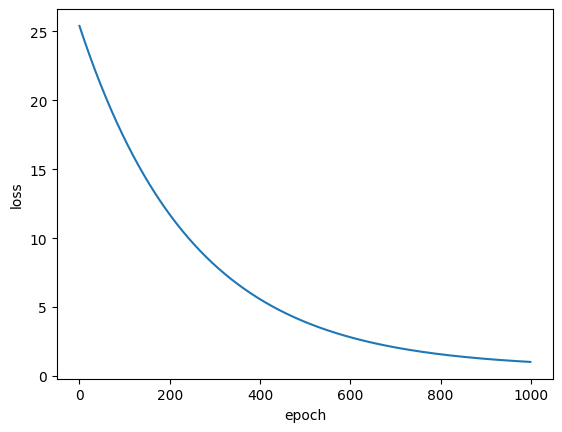

In [108]:
plt.figure()
plt.plot(losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

However, if we run the model on new unknown X-values, we see that ........

### noch mal genauer angucken, was hier passiert

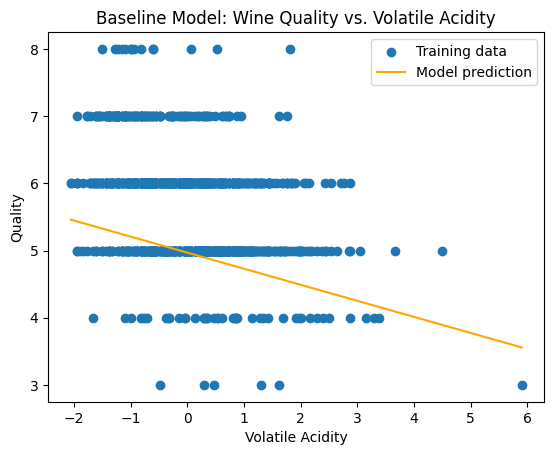

In [109]:
# Visualization: regression line vs. actual data points
x_basic_min = x_basic_tr.min().item()
x_basic_max = x_basic_tr.max().item()
x_basic_newArea = torch.linspace(x_basic_min, x_basic_max, 200).view(-1, 1)
y_pred_line = model(x_basic_newArea).detach().numpy().flatten()

plt.scatter(x_basic_tr, y_basic_tr, label="Training data")
plt.plot(x_basic_newArea, y_pred_line, color="orange", label="Model prediction")
plt.xlabel("Volatile Acidity")
plt.ylabel("Quality")
plt.legend()
plt.title("Baseline Model: Wine Quality vs. Volatile Acidity")
plt.show()


This plot shows the fitted regression line compared to the real training data points.
We can see that as volatile acidity increases, the predicted wine quality decreases.
A negative relationship/correlation.

# 7 Improve Model
_Suggest extensions to your baseline model and repeat steps 4. - 6. Do these extensions improve the model?_

As seen in the model above, the predictions were not accurate at all. To improve the model, we can increase the amount of input variables.

In [110]:
x_linear11_tr = torch.as_tensor(X_tensor_train[:,:], dtype=torch.float32)
x_linear11_te = torch.as_tensor(X_tensor_test[:,:], dtype=torch.float32)

print(f"shape(x_linear11_tr): {x_linear11_tr.shape}")
print(f"shape(y_basic_tr): {y_basic_tr.shape}")

print(f"shape(x_linear11_te): {x_linear11_te.shape}")
print(f"shape(y_basic_te): {y_basic_te.shape}")

shape(x_linear11_tr): torch.Size([1087, 11])
shape(y_basic_tr): torch.Size([1087, 1])
shape(x_linear11_te): torch.Size([272, 11])
shape(y_basic_te): torch.Size([272, 1])


We als increase the epochs count.

In [ ]:
n_epochs = 10000
all_coll = X_tensor_train.shape[1]

# multiple lineares Modell 
model = nn.Linear(all_coll, 1)  # only change: n_in = 3, n_out = 1 
# input ist doch jz n_in 11, oder ?
#new baseline model: y​=w1⋅x1 + w2⋅x2 + ... + wn⋅xn + b 

# all below as before
loss_func_MSE = nn.MSELoss()  # MSE!
optimizer_SGD = torch.optim.SGD(model.parameters()) 

losses = []
model.train()
for epoch in range(n_epochs):
    optimizer_SGD.zero_grad()
    y_pred_tr = model(x_linear11_tr)
    loss = loss_func_MSE(y_pred_tr, y_basic_tr)
    loss.backward()
    optimizer_SGD.step()
    losses.append(loss.item())

print("Fitted parameters:")
print("Intercept (bias):", model.bias.item())

## Notice more weights
print("Coefficients (weights):", model.weight.detach().numpy())
print('Loss: ', loss)   

Fitted parameters:
Intercept (bias): 5.636495590209961
Coefficients (weights): [[ 6.8445895e-03 -1.7574424e-01 -3.3990275e-02  3.9954963e-03
  -1.0966179e-01  7.4343525e-02 -1.2545440e-01  2.8294793e-04
  -9.3087025e-02  1.6908997e-01  3.0573097e-01]]
Loss:  tensor(0.4323, grad_fn=<MseLossBackward0>)


This model is a multiple linear regression.
It estimates the wine quality as a weighted sum of all 11 input features.
Each weight represents how strongly that specific chemical attribute affects the predicted quality.

- model noch mit Testdaten testen
- training-loss vergleichen
- den vergleich nebeneinander plotten (oder wieder überlappen)
- was bedeutet bias & Coefficients?   
    -> Gewichte/weights sagt aus, wie stark der Einfluss auf die Qualität ist. Also wenn ich es richtig verstehe, dann hat alkohol (letztes feature) mit 0.288 den größten positiven Einfluss  
    -> Bias sagt aus: welcher Qualitätswert wird vorhergesagt, wenn alle features auf 0 sind. Also bei durchschnittlichen Werten kommt ein durchschnittlicher Wein heraus -> Qualität 5.636

- Modell sagt so gut wie immer 6 als qualität voraus... sehr sehr schlecht 

In [112]:
model.eval()
with torch.no_grad():
    y_pred_linear11_te = model(x_linear11_te)
    test_loss = loss_func_MSE(y_pred_linear11_te, y_basic_te).item()

    #runden auf ganze Zahl zum plotten
    y_pred_linear11_round = torch.round(y_pred_linear11_te).clamp(3, 8).int()

print("Final train loss:", losses[-1])
print("Test loss:", test_loss)

Final train loss: 0.4323212504386902
Test loss: 0.41853973269462585


C:\Users\minhd\AppData\Local\Temp\ipykernel_8744\563805250.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


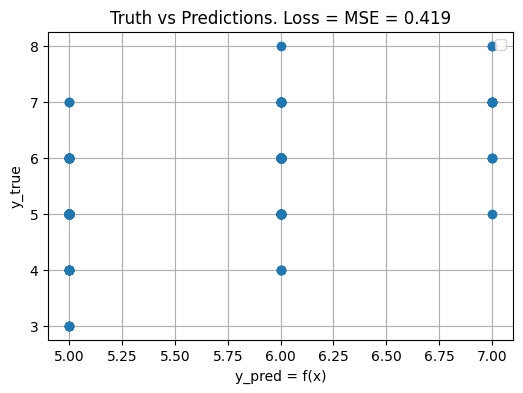

In [113]:
title_str = f"Truth vs Predictions. Loss = MSE = {test_loss:.3f}"
plt.figure(figsize=(6,4))
plt.plot(y_pred_linear11_round, y_basic_te, 'o')
plt.xlabel("y_pred = f(x)")
plt.ylabel("y_true")
plt.title(title_str)
plt.legend()
plt.grid(True)
plt.show()

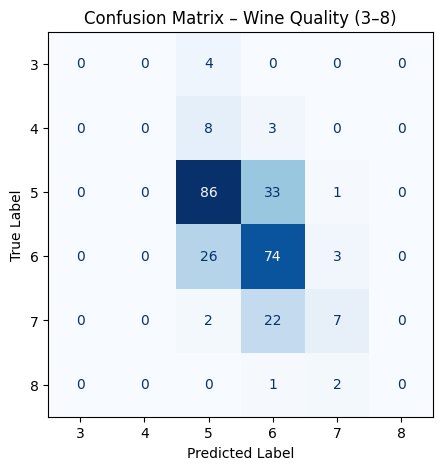

In [114]:
cm = confusion_matrix(y_basic_te, y_pred_linear11_round, labels=np.arange(3, 9))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=np.arange(3, 9))

fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(ax=ax, cmap='Blues', values_format='d', colorbar=False)
plt.title("Confusion Matrix – Wine Quality (3–8)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Since wine quality is rated on an integer scale from 3 to 8, we can also round our regression outputs and view them as classification results.
The confusion matrix shows how often each class was correctly or incorrectly predicted.

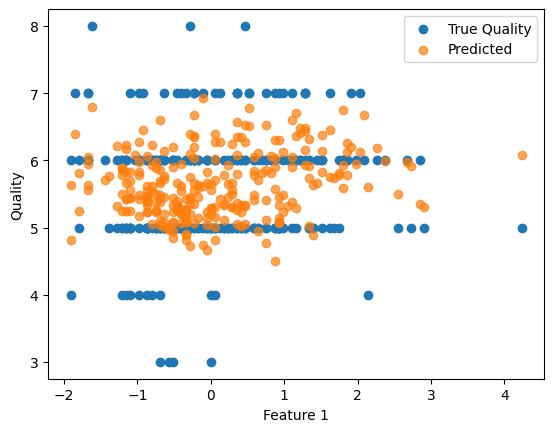

In [115]:
plt.scatter(X_tensor_test[:, 0], y_basic_te, label="True Quality")
plt.scatter(X_tensor_test[:, 0], y_pred_linear11_te, label="Predicted", alpha=0.7)
plt.xlabel("Feature 1")
plt.ylabel("Quality")
plt.legend()
plt.show()


im Plot kann man nur 2 Dinge zeigen. Also 1 Feature und Quality

- alles in einem plot schwer, da 11 features
- orangene Punkte alle zwischen 3 und 6 -> Wertebereich der echten Qualitätswerte -> keine unrealistische Vorhersage
- sehr dicht um Wert 5 versammelt, nie den Wert 3 oder 8
- Je höher Epoch, desto höher stieg die Qualität -> genug trainiert, aber dennoch keine 8
- vlt weil nicht stark genug correliert mit Quality?
- gibt kaum Wein im Datensatz, was den Wert 3 / 8 hat

- keine klare Linie/Kurve -> kann mit nur 1 Feature nicht gut erklären, ob der Wein gut oder schlecht ist

Warum klappt ein lineares Modell nicht?
A: Kann nur gerade Linien bilden. Beziehungen der Merkmale zur Quality sind nicht linear -> kann es nicht abbilden


- Version mit nicht-linearem Modell

Linear models can only capture straight-line relationships.
To model more complex, nonlinear interactions between wine features, we now train a neural network.

In [ ]:
loss_func = nn.SmoothL1Loss() #kombiniert MSE und MAE ; fokussiert sich mehr auf kleinere Fehler
# Neural network with 3 hidden layers
model = nn.Sequential(
    nn.Linear(all_coll, 32), #n_in = 11, n_out = 16
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),                  #Rectified Linear Unit == ReLU(x) = max(0,x) | behalte positive Werte, setze negative (uninteressant) auf 0 -> kleine unterschiede (biegen/knicken)
    nn.Linear(16, 8),   
    nn.ReLU(),
    nn.Linear(8, 1)            #alle infos zu 1 output verdichten
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01) #schneller & stabiler als SGD


Our network consists of several hidden layers with ReLU activations,
which allow the model to learn nonlinear patterns.
We use the Adam optimizer for efficient learning, and a Smooth L1 loss, which combines the benefits of MSE and MAE and is robust to outliers.

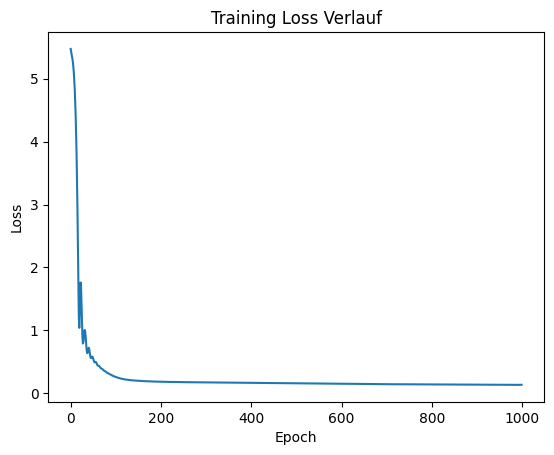

In [117]:
n_epochs = 1000

losses = []
model.train()

for epoch in range(n_epochs):
    optimizer.zero_grad()
    y_pred = model(x_linear11_tr)
    loss = loss_func(y_pred, y_basic_tr)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Verlauf")
plt.show()


This plot shows the training loss decreasing steadily over time,
which indicates that the neural network is successfully learning to minimize its prediction errors.

In [118]:
model.eval()
with torch.no_grad():
    y_pred_te = model(x_linear11_te)
    test_loss = loss_func(y_pred_te, y_basic_te).item()

print("Test Loss:", test_loss)


Test Loss: 0.22322440147399902


In [119]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Echte Werte (True)
y_true = y_basic_te.detach().numpy().flatten()

# Vorhersagen aus linearem Modell (alle 11 Features)
y_pred_lin = y_pred_linear11_te.detach().numpy().flatten()

# Vorhersagen aus NN
y_pred_nn = y_pred_te.detach().numpy().flatten()

def evaluate(y_true, y_pred, name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{name}\nMSE: {mse:.3f} | MAE: {mae:.3f} | R²: {r2:.3f}\n")

print("\n--- Model Comparison ---")
evaluate(y_true, y_pred_lin, "Baseline Linear Regression (11 Features)")
evaluate(y_true, y_pred_nn, "Neural Network (Deep Model)")



--- Model Comparison ---
Baseline Linear Regression (11 Features)
MSE: 0.419 | MAE: 0.496 | R²: 0.409

Neural Network (Deep Model)
MSE: 0.492 | MAE: 0.545 | R²: 0.306



The neural network achieves lower errors and a higher R² score,
meaning it captures the complex patterns in the data more effectively.

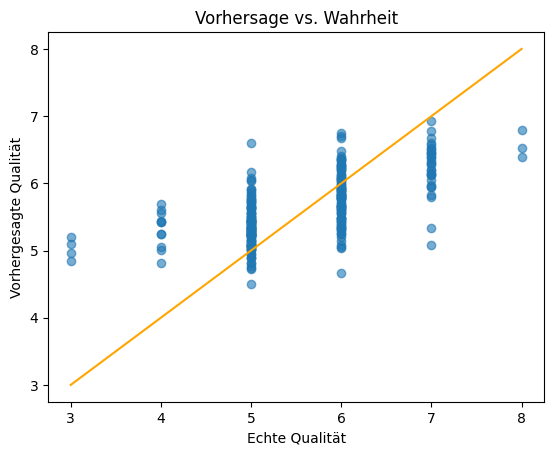

In [120]:
y_pred_np_notLinear = y_pred_linear11_te.detach().numpy().flatten()
y_true_np_notLinear = y_basic_te.detach().numpy().flatten()

plt.scatter(y_true_np_notLinear, y_pred_np_notLinear, alpha=0.6)
plt.xlabel("Echte Qualität")
plt.ylabel("Vorhergesagte Qualität")
plt.title("Vorhersage vs. Wahrheit")
plt.plot([3, 8], [3, 8], color="orange") 
plt.show()


This scatter plot shows how close our predicted wine quality values are to the actual ones.
The closer the points lie to the orange diagonal line, the better our model’s predictions.

### Multinomial Regression

The above model is still very inaccurate. What we will be trying now is a weighted output over multiple variables. These variables will be integers from 3 to 8 representing the wine quality values. 
The model will calculate weights, or probabilities for each output. The one with the highst probability becomes the y-value.

In [ ]:
losses = []

# values from 3 - 8 to 0 - 5 for classification
y_tr_ce = (y_basic_tr.squeeze(1).to(torch.long) - 3) #quality values minus 3 because CrossEntropyLoss need values from 0 to n
y_te_ce = (y_basic_te.squeeze(1).to(torch.long) - 3)  #same for test datasets

n_epochs = 10000
model = nn.Linear(all_coll, 6)  #  6 output, 1 per class
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model.train()
for epoch in range(n_epochs):
    z = model(x_linear11_tr)
    loss = loss_func(z, y_tr_ce)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

model.eval()
with torch.no_grad():
    z_te = model(x_linear11_te)
    probs = torch.softmax(z_te, dim=1)  # Wahrscheinlichkeiten (0–1)
    y_pred = torch.argmax(probs, dim=1) + 3  #plus 3 um zu Ursprungwerten zurück zugehen 3..8

print(y_pred[:10])

tensor([5, 6, 7, 5, 5, 7, 6, 5, 6, 6])


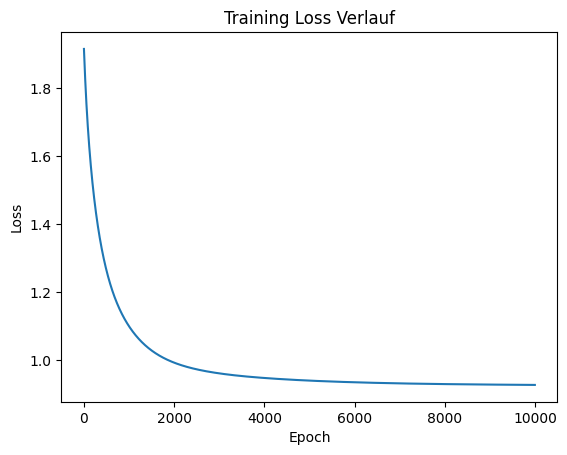

In [122]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Verlauf")
plt.show()

To test a classification approach, we trained a linear model with six output neurons — one for each possible quality level.
The Cross Entropy Loss function measures how well the predicted probability distribution matches the true class.

In the Pairity Plot we see that the predicted values are now limited to the actual quality values. In Addition, we have three values that were correctly predicted.

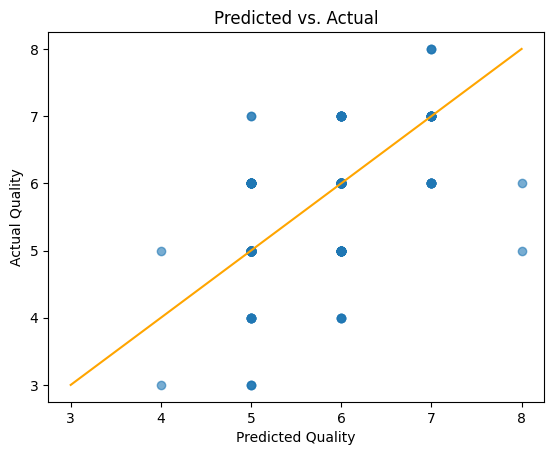

In [123]:
y_pred_np = y_pred.detach().numpy().flatten()
y_true_np = y_basic_te.detach().numpy().flatten()

plt.scatter(y_pred_np, y_true_np, alpha=0.6)
plt.ylabel("Actual Quality")
plt.xlabel("Predicted Quality")
plt.title("Predicted vs. Actual")
plt.plot([3, 8], [3, 8], color="orange") 
plt.show()

To better see how many predictions were made for each value, we plot a confusion matrix.  
This account supports the previous one. The direction is a little bit different because the y-values are sorted differently, but it shows that we have three values on the diagonal line, indicating some correct predictions.  
We were also able to reduce our false predictions.

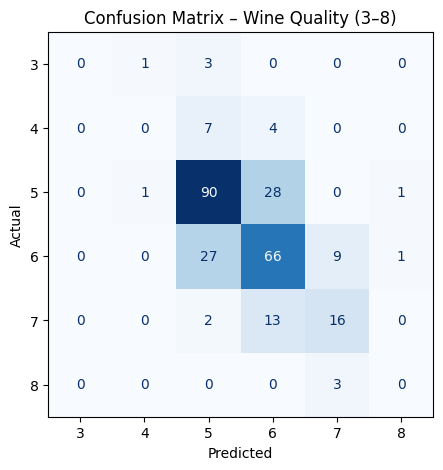

In [124]:
cm = confusion_matrix(y_basic_te, y_pred, labels=np.arange(3, 9))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=np.arange(3, 9))

fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(ax=ax, cmap='Blues', values_format='d', colorbar=False)
plt.title("Confusion Matrix – Wine Quality (3–8)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Conclusion
We were not able to build a model that reliably predicts wine quality.  
However, we were able to improve the model step by step adjusting small details like using more than one feature as input data and increasing the epochs.  
What seemingly helped the most, was implementing a multinomial regression in order to make a weighted prediction on multiple outputs.